# 1. Connecting Pandas to the Chinook Oracle Database and loading tables into separate DataFrames

In [5]:
import pandas as pd
import oracledb
from sqlalchemy import create_engine, inspect
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway,shapiro, kstest, normaltest, probplot,zscore,f_oneway,kruskal,pearsonr,chi2_contingency
from scipy import stats  

In [6]:
username = 'CHINOOK_DATABASE'  
password = 'Oracle19c'   
dsn = '(DESCRIPTION=(ADDRESS=(PROTOCOL=TCP)(HOST=DESKTOP-P9U8EDG)(PORT=1521))(CONNECT_DATA=(SERVICE_NAME=orcle19c)))'

# Create a SQLAlchemy engine
engine = create_engine(f'oracle+oracledb://{username}:{password}@{dsn}', max_identifier_length=128)

# Establish the database connection
connection = engine.connect()
print("Connected to Oracle Database successfully.")

# Retrieve all table names from the Chinook database
query = """
SELECT table_name
FROM all_tables
WHERE owner = 'CHINOOK_DATABASE'
"""
tables_df = pd.read_sql(query, connection)

# Dictionary to hold DataFrames for each table
dataframes = {}

# Read each table into a DataFrame
for table_name in tables_df['table_name']:
  
    table_query = f"SELECT * FROM {table_name}"
    df = pd.read_sql(table_query, connection)
    dataframes[table_name] = df

# Close the connection
connection.close()

Connected to Oracle Database successfully.


In [7]:
album = dataframes['ALBUM']
artist = dataframes['ARTIST']
customer = dataframes['CUSTOMER']
employee = dataframes['EMPLOYEE']
genre = dataframes['GENRE']
invoice = dataframes['INVOICE']
invoiceline = dataframes['INVOICELINE']
mediatype = dataframes['MEDIATYPE']
playlist = dataframes['PLAYLIST']
playlisttrack = dataframes['PLAYLISTTRACK']
track = dataframes['TRACK']

# 2. Preliminary data analysis

In [8]:
for table_name, df in dataframes.items():
    print(f"--- Table: {table_name} ---")
    print(f"Shape: {df.shape}")  # Display the number of rows and columns
    print(f"Info: {df.info()}") # Display information about the DataFrame including data types and non-null counts
    print(f"Head: {df.head()}") # Display the first few rows of the DataFrame 
    print(f"Columns: {df.columns.tolist()}")  # Display column names
    print(f"Data types:\n{df.dtypes}")  # Display data types
    print(f"Missing values:\n{df.isnull().sum()}")  # Display the number of missing values in each column
    print(f"Descriptive statistics:\n{df.describe(include='all')}")  # Display summary statistics
    print("\n")

--- Table: ALBUM ---
Shape: (347, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   albumid   347 non-null    int64 
 1   title     347 non-null    object
 2   artistid  347 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 8.3+ KB
Info: None
Head:    albumid                                  title  artistid
0        1  For Those About To Rock We Salute You         1
1        2                      Balls to the Wall         2
2        3                      Restless and Wild         2
3        4                      Let There Be Rock         1
4        5                               Big Ones         3
Columns: ['albumid', 'title', 'artistid']
Data types:
albumid      int64
title       object
artistid     int64
dtype: object
Missing values:
albumid     0
title       0
artistid    0
dtype: int64
Descriptive statistics:
           albumid    

#  Identification of Key Variables and Their Distributions
3. What do you consider to be the key variables? Examine their distributions using appropriate plots.
4. What palettes do you think would help you better understand the data? Use them and report your findings.
5. Using 3 different methods, assess the normality of the variables.


The key variables that determine the business situation and profitability are as follows: 

•	Sales amount and income 

•	Customers in terms of loyalty, growth in the number of users and customer retention 

•	Products (Tracks)

•	Suppliers (Artists, Albums producers)


A whole business overview

In [9]:
# 1. Total Revenue  
total_revenue = invoice['total'].sum() 
print(f"total_revenue: {total_revenue}")

# 2. Average Price 
average_price_per_track = track['unitprice'].mean()  
print(f"average_price_per_track: {average_price_per_track}")

# 3. Sales Volume  
sales_volume = invoiceline['quantity'].sum() 
print(f"sales_volume: {sales_volume}") 

# 4. Year-wise Sales
query_year_wise_sales= """
SELECT EXTRACT(YEAR FROM I.InvoiceDate) AS Year,  
       SUM(IL.Quantity) AS TotalTracksSold,
       SUM(IL.Quantity*IL.Unitprice) AS TotalSales   
FROM Invoice I  
JOIN InvoiceLine IL ON I.InvoiceId = IL.InvoiceId  
GROUP BY EXTRACT(YEAR FROM I.InvoiceDate)  
ORDER BY Year
"""

year_wise_sales_df = pd.read_sql(query_year_wise_sales, engine)
year_wise_sales_df

total_revenue: 2328.6
average_price_per_track: 1.0508050242649158
sales_volume: 2240


,year,totaltrackssold,totalsales
0,2021,454,449.46
1,2022,455,481.45
2,2023,442,469.58
3,2024,447,477.53
4,2025,442,450.58


Calculating Key Metrics to Gain Insights into the Company's Profitability in 2025

total_revenue_2025: 450.5799999999999
monthly_revenue: invoicedate
2025-01-31    37.62
2025-02-28    27.72
2025-03-31    37.62
2025-04-30    33.66
2025-05-31    37.62
2025-06-30    37.62
2025-07-31    37.62
2025-08-31    37.62
2025-09-30    37.62
2025-10-31    37.62
2025-11-30    49.62
2025-12-31    38.62
Freq: ME, Name: total, dtype: float64
revenue_growth_rate: invoicedate
2025-01-31     0.000000
2025-02-28   -26.315789
2025-03-31    35.714286
2025-04-30   -10.526316
2025-05-31    11.764706
2025-06-30     0.000000
2025-07-31     0.000000
2025-08-31     0.000000
2025-09-30     0.000000
2025-10-31     0.000000
2025-11-30    31.897927
2025-12-31   -22.168480
Freq: ME, Name: total, dtype: float64


C:\Users\Snapp\AppData\Local\Temp\ipykernel_15176\3995368121.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_revenue = sales_2025_df.resample('M', on='invoicedate')['total'].sum()


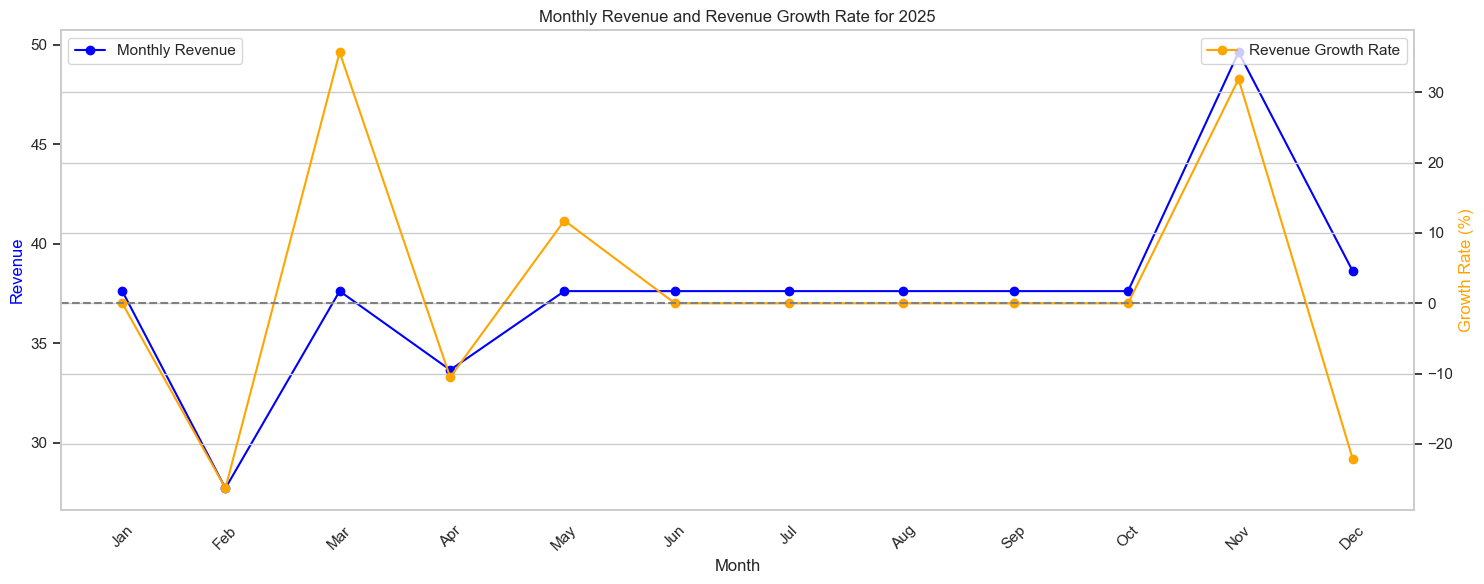

new_customer_2025: 12
customer_acquisition_revenue: 14.024999999999999


In [21]:
query_sales_2025 ="""
Select *  from invoice i
where EXTRACT(YEAR FROM i.invoicedate) = 2025
"""
sales_2025_df = pd.read_sql(query_sales_2025, engine)

# 1. Total Revenue in 2025 
total_revenue_2025 = sales_2025_df ['total'].sum() 
print(f"total_revenue_2025: {total_revenue_2025}")

# 2. Revenue Growth Rate (Assuming monthly revenue data is available)  
# Here we'll sum the revenue by month, then calculate growth  
monthly_revenue = sales_2025_df.resample('M', on='invoicedate')['total'].sum()  
revenue_growth_rate = monthly_revenue.pct_change().fillna(0) * 100  
print(f"monthly_revenue: {monthly_revenue}")
print(f"revenue_growth_rate: {revenue_growth_rate}")

  
# Line Plot for Monthly Revenue and Revenue Growth Rate
fig, ax1 = plt.subplots(figsize=(15, 6))  

# Line Plot for Monthly Revenue  
ax1.plot(monthly_revenue.index, monthly_revenue, marker='o', label='Monthly Revenue', color='blue')  
ax1.set_title('Monthly Revenue and Revenue Growth Rate for 2025')  
ax1.set_xlabel('Month')  
ax1.set_ylabel('Revenue', color='blue')  
ax1.set_xticks(monthly_revenue.index)  
ax1.set_xticklabels(monthly_revenue.index.strftime('%b'), rotation=45)  
ax1.grid()  
ax1.legend(loc='upper left')  

# Create a secondary y-axis for Revenue Growth Rate  
ax2 = ax1.twinx()  
ax2.plot(revenue_growth_rate.index, revenue_growth_rate, marker='o', color='orange', label='Revenue Growth Rate')  
ax2.set_ylabel('Growth Rate (%)', color='orange')  
ax2.axhline(0, color='grey', linestyle='--')  # Line to indicate 0% growth  
ax2.legend(loc='upper right')  

# Adjust layout  
plt.tight_layout()  
plt.show()


query_Customer_Acquisition= """
SELECT DISTINCT i.customerid  
FROM invoice i  
WHERE   
    i.customerid IN (  
        SELECT   
            i.customerid  
        FROM   
            invoice i  
        WHERE   
            EXTRACT(YEAR FROM i.invoicedate) IN (2021, 2022, 2023)  
        GROUP BY   
            i.customerid  
        HAVING   
            NOT EXISTS (  
                SELECT 1   
                FROM invoice i2   
                WHERE   
                    i.customerid = i2.customerid   
                    AND EXTRACT(YEAR FROM i2.invoicedate) = 2024  
            )   
    )  
    AND EXTRACT(YEAR FROM i.invoicedate) = 2025
""" 

Customer_Acquisition_df = pd.read_sql(query_Customer_Acquisition, engine)

# 6. Customer Acquisition Revenue (For new customers in 2025)  

# Calculate the number of unique new customers  
new_customers = Customer_Acquisition_df['customerid'].nunique()
print(f"new_customer_2025: {new_customers}")

# Calculate total revenue generated by only new customers  
total_revenue_new_customers = sales_2025_df[sales_2025_df['customerid'].isin(Customer_Acquisition_df['customerid'])]['total'].sum()  

# Calculate customer acquisition cost  
customer_acquisition_revenue = total_revenue_new_customers / new_customers if new_customers else 0
print(f"customer_acquisition_revenue: {customer_acquisition_revenue}")

Note 1. If the sales and marketing costs for attracting new customers were available, we could provide a better perspective on the profitability of the business through a comparison of Customer Acquisition Cost (CAC) and Customer Lifetime Value (CLV). It is worth mentioning that the customers considered as new customers are actually those who were customers of the company during the years 2021, 2022, and 2023, did not make any purchases from the company in 2024, and then resumed purchasing from the company in 2025. Therefore, the company's actions in this regard are more about customer retention rather than attracting new and potential customers;

Note 2. As per conducted analysis, business was stable in terms of quantity and amount of sales over the years and does not have significant growth and profitability. 

---------------------------------------------------

Top 10 Customers Generating the Highest Revenue

Focus on Key Accounts: It highlights the most valuable customers, allowing the company to prioritize engagement and relationship-building with them.

   revenue  customerid           customername  billingcountry
5    49.62           6            Helena Holý  Czech Republic
6    42.62           7          Astrid Gruber         Austria
4    40.62           5  František Wichterlová  Czech Republic
0    39.62           1         Luís Gonçalves          Brazil
2    39.62           3      François Tremblay          Canada
3    39.62           4           Bjørn Hansen          Norway
1    37.62           2          Leonie Köhler         Germany
7    37.62           8           Daan Peeters         Belgium
8    37.62           9           Kara Nielsen         Denmark
9    37.62          10        Eduardo Martins          Brazil


C:\Users\Snapp\AppData\Local\Temp\ipykernel_15176\1018850723.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='revenue', y='customername', data=customer_revenue_df, palette='viridis', legend=False)


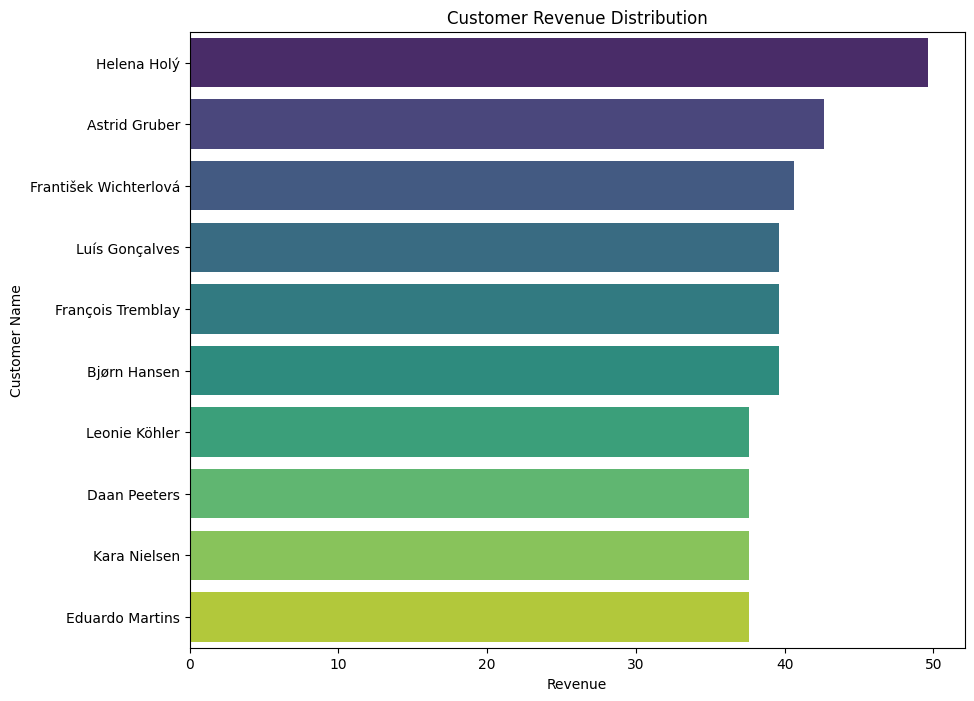

In [13]:
query = """  
SELECT * FROM (  
    SELECT SUM(i.Total) AS revenue,  
           i.CustomerId,  
           c.FirstName || ' ' || c.LastName AS CustomerName, billingcountry  
    FROM invoice i  
    JOIN customer c ON i.CustomerId = c.CustomerId  
    GROUP BY i.CustomerId, c.FirstName, c.LastName, billingcountry  
)  
WHERE ROWNUM <= 10  
"""  

# Execute the query and read into DataFrame  
customer_revenue_df = pd.read_sql(query, engine)  

# Sort the DataFrame  
customer_revenue_df = customer_revenue_df.sort_values(by='revenue', ascending=False)  
print(customer_revenue_df)


# Create a barplot  
plt.figure(figsize=(10, 8))  
barplot = sns.barplot(x='revenue', y='customername', data=customer_revenue_df, palette='viridis', legend=False)  
plt.title('Customer Revenue Distribution')  
plt.xlabel('Revenue')  
plt.ylabel('Customer Name')  
plt.show()

Customer Distribution by Country

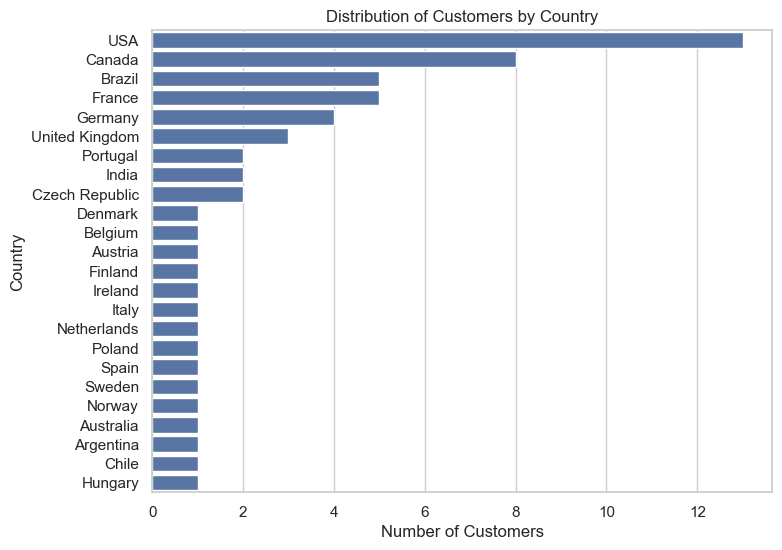

In [14]:
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.countplot(y=customer['country'], order=customer['country'].value_counts().index)
plt.title('Distribution of Customers by Country')
plt.xlabel('Number of Customers')
plt.ylabel('Country')
plt.show()

Revenue by Country

    revenue  billingcountry
16   523.06             USA
18   303.96          Canada
14   195.10          France
5    190.10          Brazil
11   156.48         Germany
22   112.86  United Kingdom
12    90.24  Czech Republic
13    77.24        Portugal
21    75.26           India
10    46.62           Chile
1     45.62         Ireland
23    45.62         Hungary
3     42.62         Austria
0     41.62         Finland
8     40.62     Netherlands
6     39.62          Norway
20    38.62          Sweden
9     37.62           Italy
7     37.62           Spain
15    37.62         Denmark
17    37.62       Australia
4     37.62       Argentina
19    37.62         Belgium
2     37.62          Poland


C:\Users\Snapp\AppData\Local\Temp\ipykernel_15176\3420421392.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='revenue', y='billingcountry', data=revenue_by_country_df, palette='viridis', legend=False)


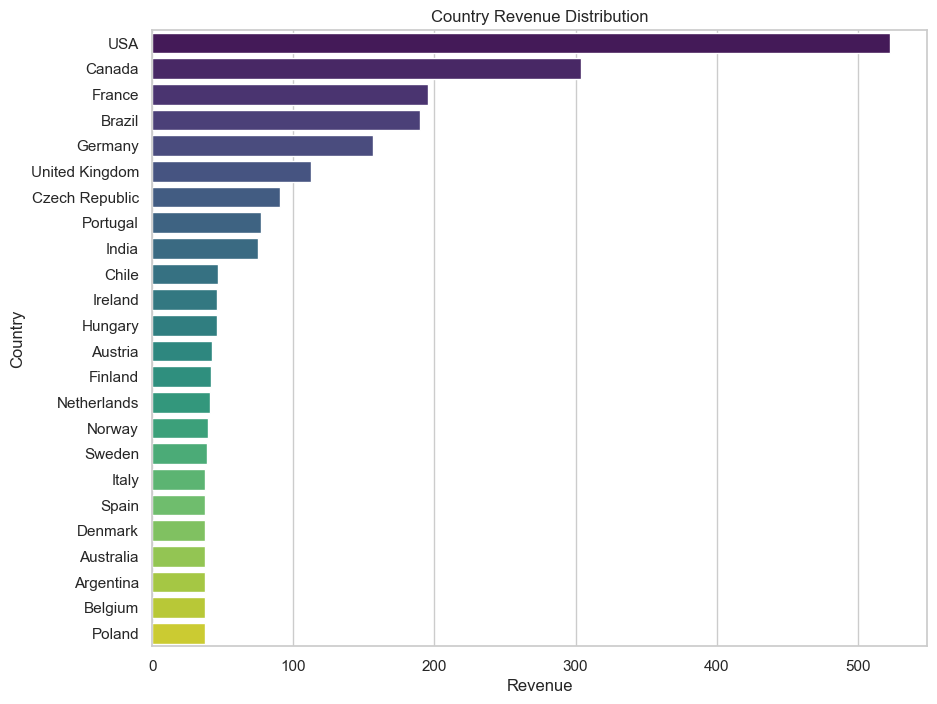

In [15]:
query_revenue_by_country = """  
SELECT * FROM (  
    SELECT SUM(i.Total) AS revenue,  
           i.billingcountry 
           FROM invoice i  
    GROUP BY billingcountry  
)  
"""  

# Execute the query and read into DataFrame  
revenue_by_country_df = pd.read_sql(query_revenue_by_country, engine)  

# Sort the DataFrame  
revenue_by_country_df= revenue_by_country_df.sort_values(by='revenue', ascending=False)  
print(revenue_by_country_df)


# Create a barplot  
plt.figure(figsize=(10, 8))  
barplot = sns.barplot(x='revenue', y='billingcountry', data=revenue_by_country_df, palette='viridis', legend=False)  
plt.title('Country Revenue Distribution')  
plt.xlabel('Revenue')  
plt.ylabel('Country')  
plt.show()

Revenue Distribution by Genre

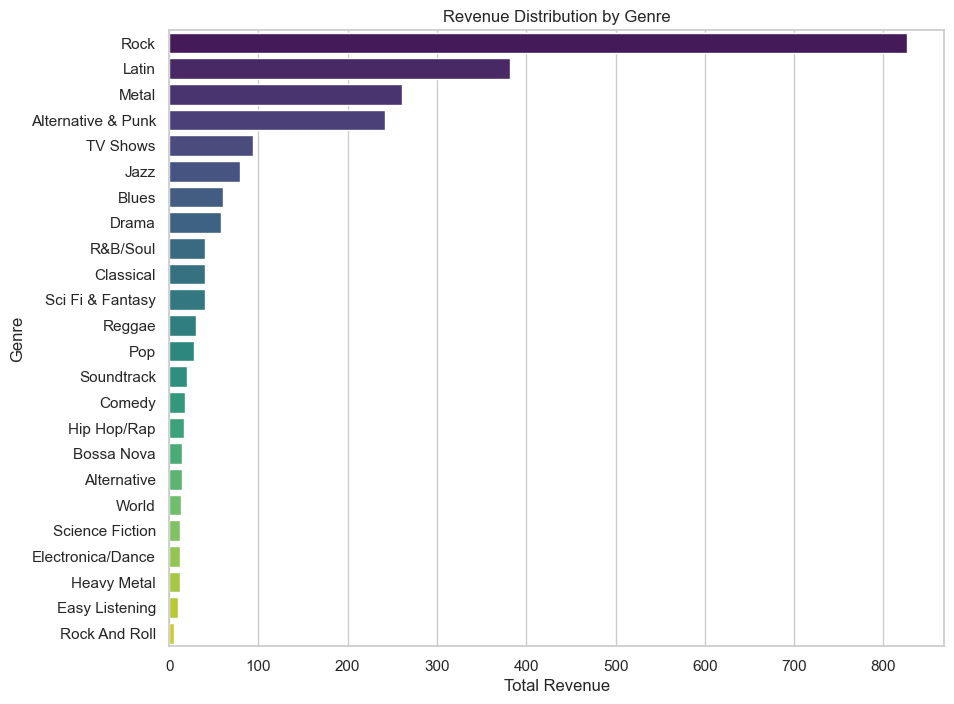

In [16]:
query_genre_revenue = """
select g.Name as genre_name,SUM(il.UnitPrice * il.Quantity) AS TotalRevenue 
from invoiceline il
join track t on il.TrackId = t.TrackId
join genre g on t.GenreId = g.GenreId
group by g.Name
"""
genre_revenue_df = pd.read_sql(query_genre_revenue, engine)
genre_revenue_df = genre_revenue_df.sort_values(by='totalrevenue', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='totalrevenue', y='genre_name', data=genre_revenue_df, palette='viridis', hue='genre_name', dodge=False, legend=False)
plt.title('Revenue Distribution by Genre')
plt.xlabel('Total Revenue')
plt.ylabel('Genre')
plt.show()

Top 10 Albums by Revenue

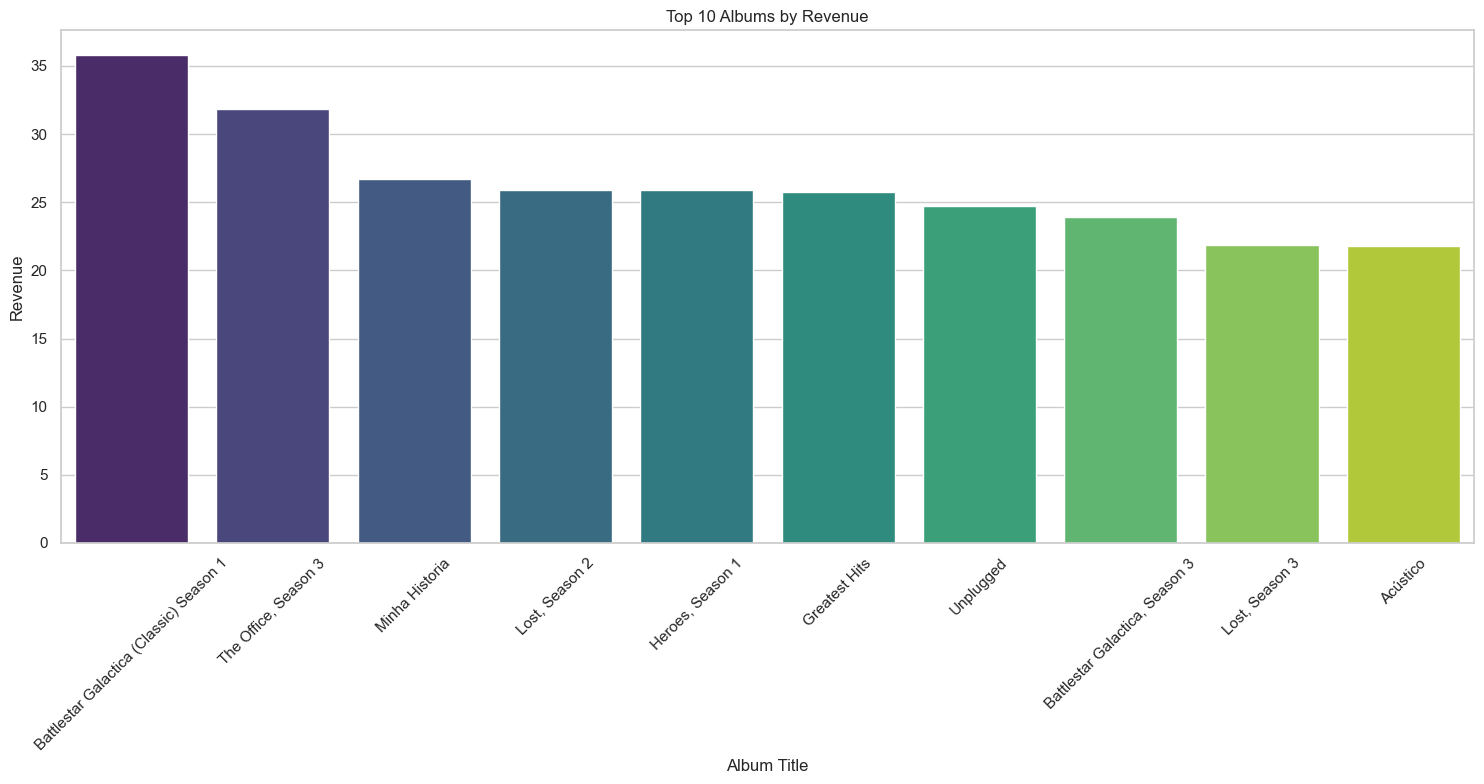

In [17]:
query_album_revenue = """
select * from 
(SELECT SUM(il.UnitPrice * il.Quantity) AS Totalrevenue, a.title as Albumtitle
FROM invoice i
JOIN invoiceline il ON i.InvoiceId = il.InvoiceId
JOIN track t ON il.TrackId = t.TrackId
JOIN album a ON t.AlbumId = a.AlbumId
GROUP BY a.Title, a.AlbumId
ORDER BY 1 DESC)
WHERE ROWNUM <= 10 
"""

album_revenue_df =pd.read_sql(query_album_revenue, engine)

sns.set(style="whitegrid")
plt.figure(figsize=(15, 8))
sns.barplot(y='totalrevenue', x='albumtitle', data=album_revenue_df, palette='viridis',legend=False,hue='albumtitle')
plt.title('Top 10 Albums by Revenue')
plt.xlabel('Album Title')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Distribution of Total Revenue of each Tracks 

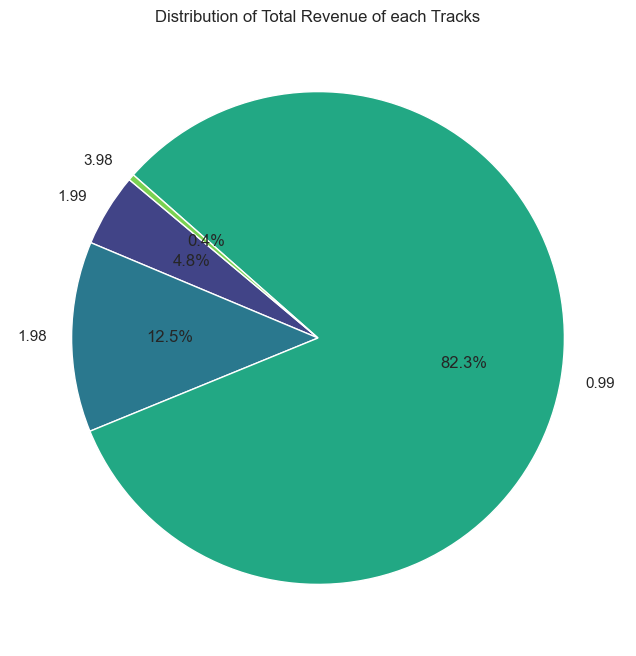

In [18]:
query_count_of_total_revenue_of_track = """
with cte as (select SUM(il.UnitPrice * il.Quantity) AS Revenue  from invoiceline il
join track t on il.trackid =t.trackid
group by concat(il.trackid,t.Name))
select count(*) count,Revenue as Total_Revenue from cte
group by Revenue
"""

count_of_total_revenue_of_track_df = pd.read_sql(query_count_of_total_revenue_of_track, engine)

# Plot the count of tracks against their total revenue using a pie chart
plt.figure(figsize=(10, 8))
plt.pie(count_of_total_revenue_of_track_df['count'], labels=count_of_total_revenue_of_track_df['total_revenue'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette("viridis", len(count_of_total_revenue_of_track_df)))
plt.title('Distribution of Total Revenue of each Tracks')
plt.show()

Artists with low track sales

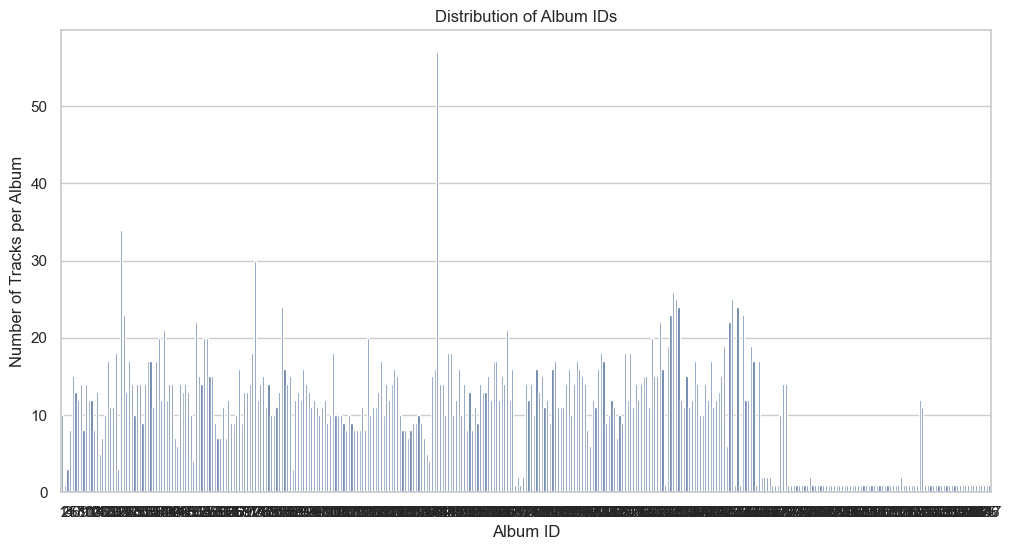

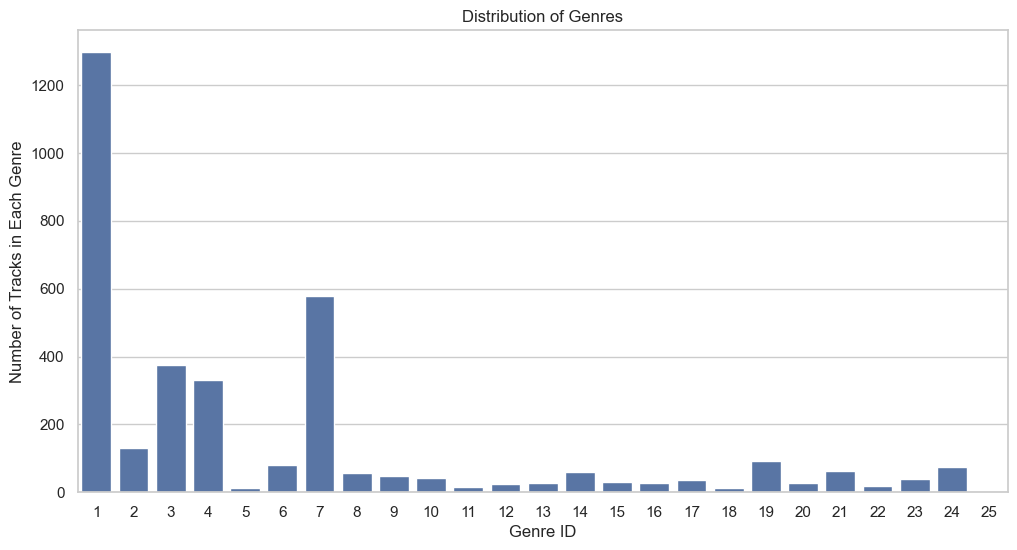

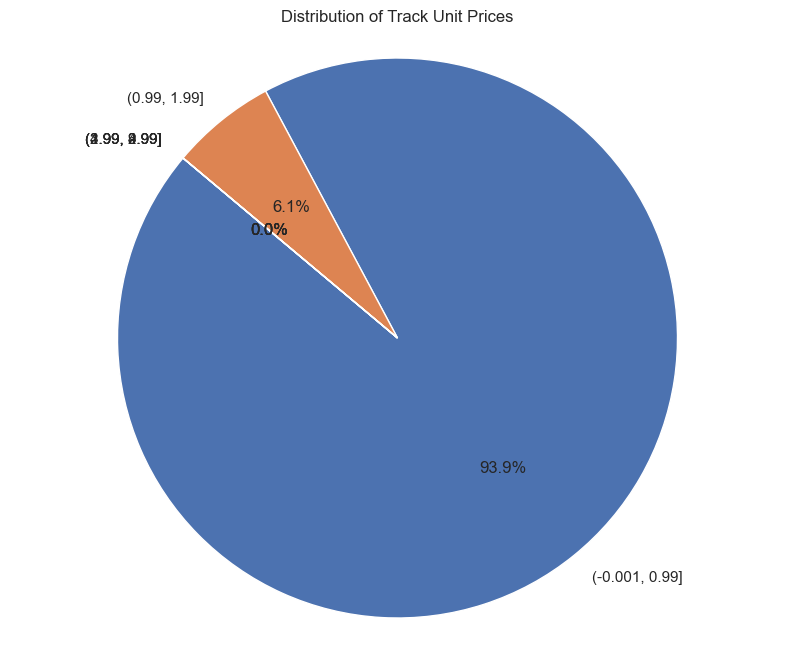

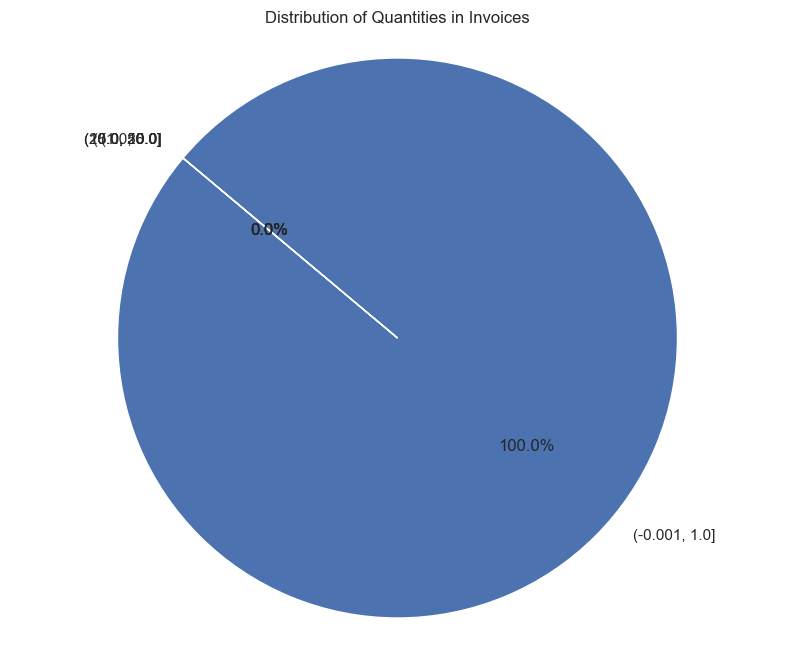

In [60]:


# Analyze the distribution of Album IDs  
plt.figure(figsize=(12, 6))  
sns.countplot(data=track, x='albumid')  
plt.title('Distribution of Album IDs')  
plt.xlabel('Album ID')  
plt.ylabel('Number of Tracks per Album')  
plt.show()  

# Analyze the distribution of Genres  
plt.figure(figsize=(12, 6))  
sns.countplot(data=track, x='genreid')  
plt.title('Distribution of Genres')  
plt.xlabel('Genre ID')  
plt.ylabel('Number of Tracks in Each Genre')  
plt.show()  

# Plotting the Unit Prices Pie Plot  
plt.figure(figsize=(10, 8))  
plt.pie(unitprice_counts, labels=unitprice_counts.index.astype(str), autopct='%1.1f%%', startangle=140)  
plt.title('Distribution of Track Unit Prices')  
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.  
plt.show()  

# Grouping 'quantity' into bins for pie chart representation  
quantity_bins = pd.cut(invoiceline['quantity'], bins=[0, 1, 5, 10, 20, 50], include_lowest=True)  
quantity_counts = quantity_bins.value_counts()  

# Plotting the Quantities Pie Plot  
plt.figure(figsize=(10, 8))  
plt.pie(quantity_counts, labels=quantity_counts.index.astype(str), autopct='%1.1f%%', startangle=140)  
plt.title('Distribution of Quantities in Invoices')  
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.  
plt.show()  

# 5. Using 3 different methods, assess the normality of the variables.

Check Normality of data using Plots and Statistical test 

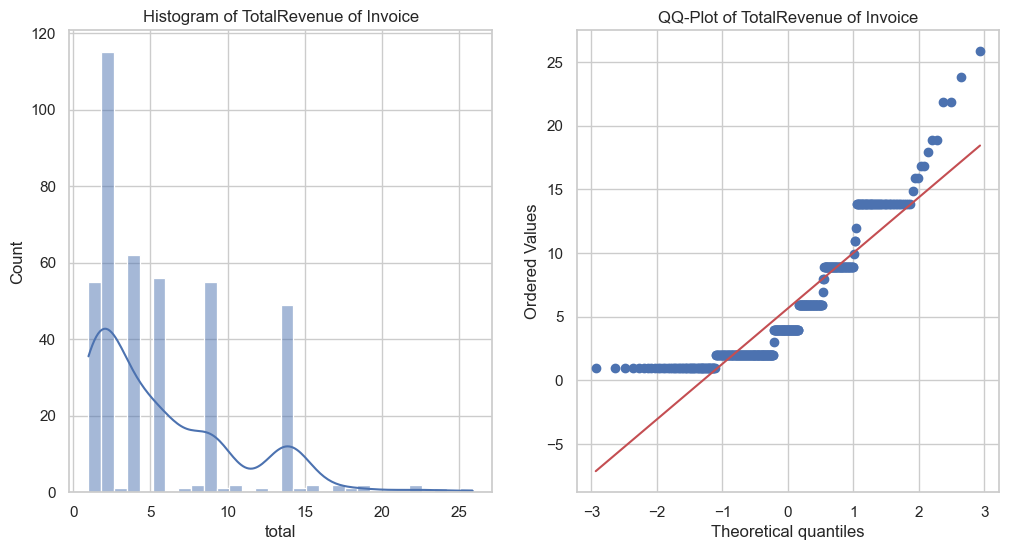

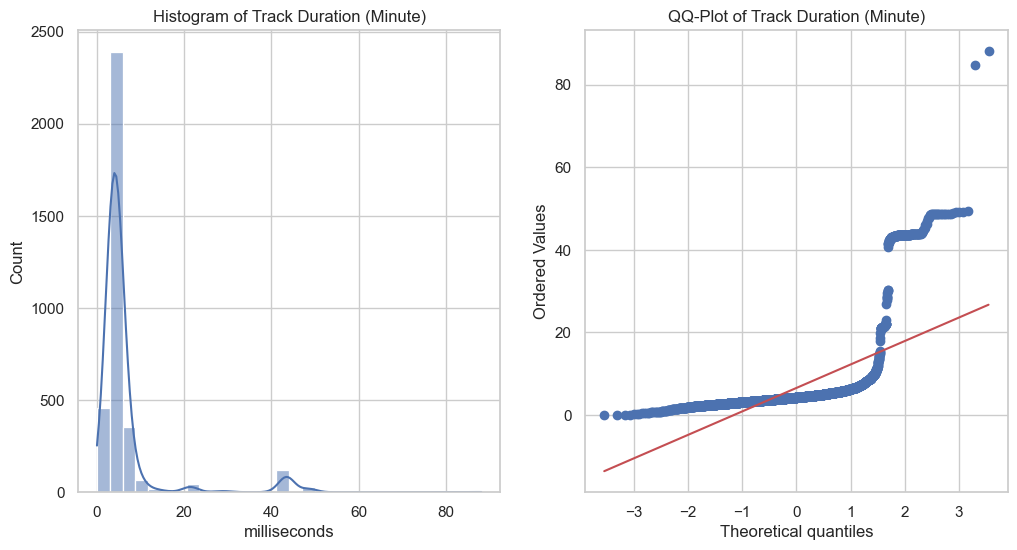

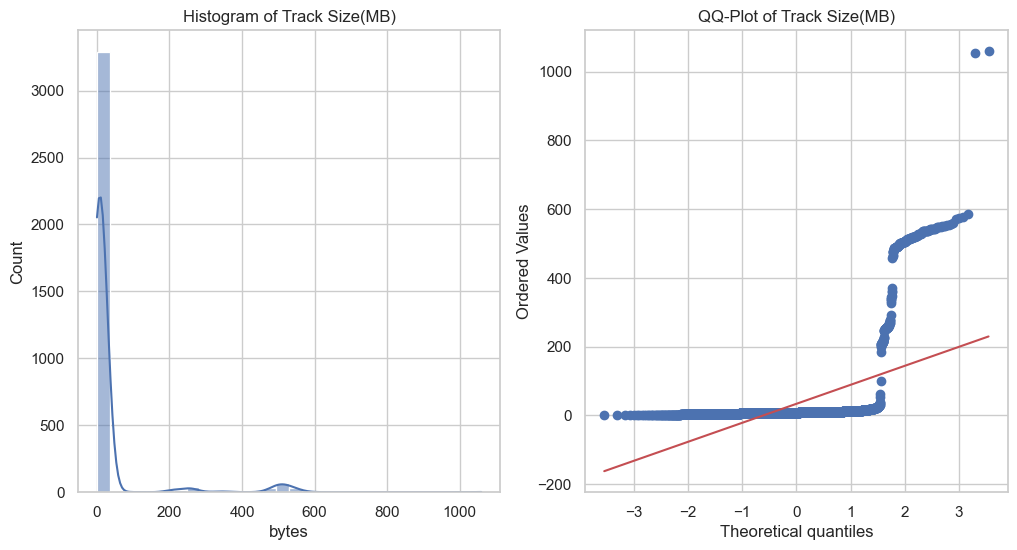

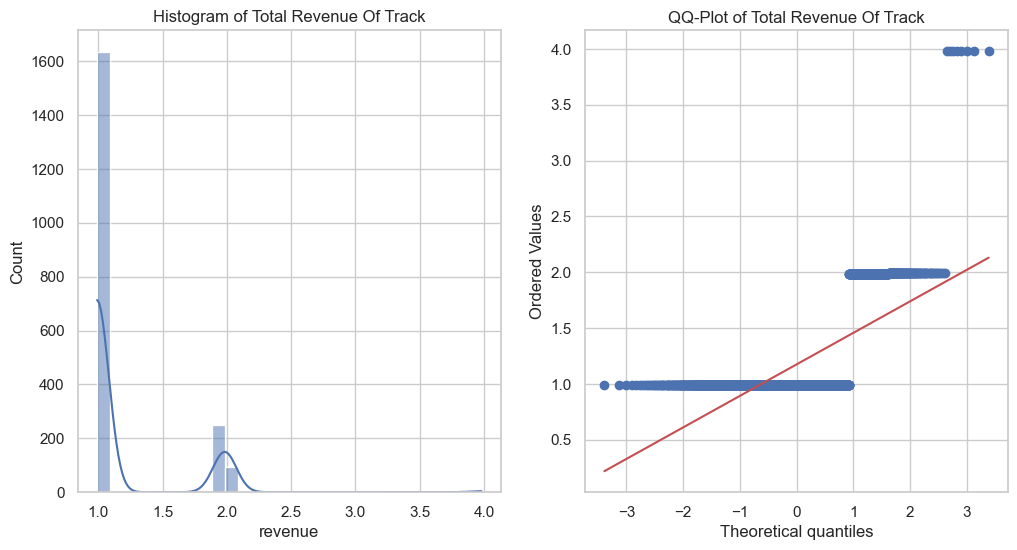

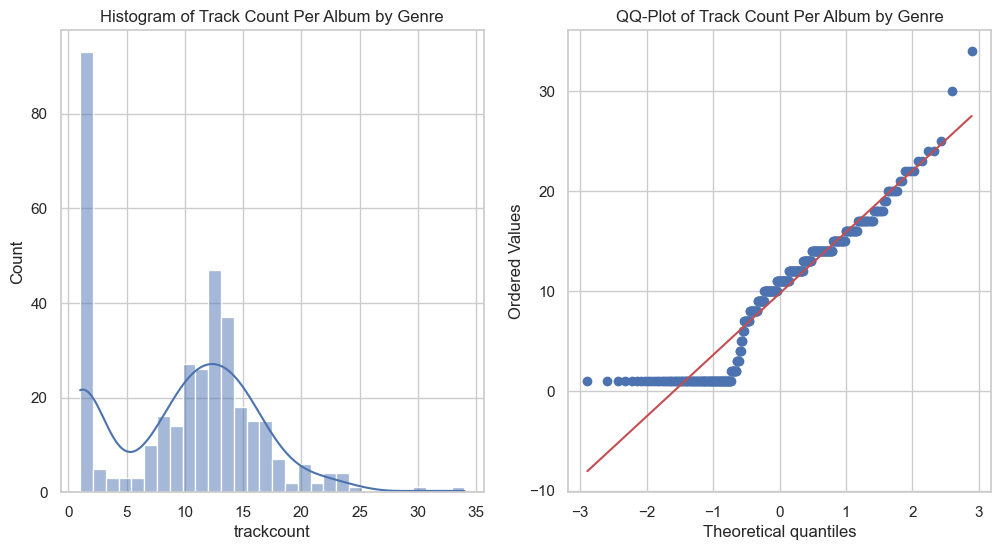

Statistical Tests for TotalRevenue of Invoice
Shapiro-Wilk Test: 
Statistics=0.8367111017894937, p-value=3.4001843897448504e-20
Reject the null hypothesis: The data does not appear to be normally distributed.

Kolmogorov-Smirnov Test:
Statistics=0.2032404223670664, p-value=2.1324912710028523e-15
Reject the null hypothesis: The data does not appear to be normally distributed.

D'Agostino's K^2 Test:
Statistics=77.62088899270081, p-value=1.3958479562510736e-17
Reject the null hypothesis: The data does not appear to be normally distributed.

Statistical Tests for Track Duration (Minute)
Shapiro-Wilk Test: 
Statistics=0.4069350980582942, p-value=2.7287436202313686e-75
Reject the null hypothesis: The data does not appear to be normally distributed.

Kolmogorov-Smirnov Test:
Statistics=0.3600097273687073, p-value=0.0
Reject the null hypothesis: The data does not appear to be normally distributed.

D'Agostino's K^2 Test:
Statistics=2821.043827696705, p-value=0.0
Reject the null hypothesis: Th

In [50]:
# Visual Method: Histograms and QQ-Plots
def plot_histogram_and_qqplot(data, title):
    plt.figure(figsize=(12, 6))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data,bins=30, kde=True)
    plt.title(f'Histogram of {title}')

    # QQ-Plot
    plt.subplot(1, 2, 2)
    probplot(data, dist="norm", plot=plt)
    plt.title(f'QQ-Plot of {title}')
    
    plt.show()

# Statistical Tests
def perform_statistical_tests(data, variable_name):
    print(f"Statistical Tests for {variable_name}")

    # Shapiro-Wilk Test
    shapiro_stat, shapiro_p = shapiro(data)
    print(f"Shapiro-Wilk Test: \nStatistics={shapiro_stat}, p-value={shapiro_p}")
    alpha = 0.05
    if shapiro_p < alpha:
        print('Reject the null hypothesis: The data does not appear to be normally distributed.\n')
    else:
        print('Fail to reject the null hypothesis: The data appears to be normally distributed.\n')

    # Kolmogorov-Smirnov Test
    ks_stat, ks_p = kstest(data, 'norm', args=(data.mean(), data.std()))
    print(f"Kolmogorov-Smirnov Test:\nStatistics={ks_stat}, p-value={ks_p}")
    if ks_p < alpha:
        print('Reject the null hypothesis: The data does not appear to be normally distributed.\n')
    else:
        print('Fail to reject the null hypothesis: The data appears to be normally distributed.\n')

    # D'Agostino's K^2 Test
    dagostino_stat, dagostino_p = normaltest(data)
    print(f"D'Agostino's K^2 Test:\nStatistics={dagostino_stat}, p-value={dagostino_p}")
    if dagostino_p < alpha:
        print('Reject the null hypothesis: The data does not appear to be normally distributed.\n')
    else:
        print('Fail to reject the null hypothesis: The data appears to be normally distributed.\n')

# Descriptive Methods: Summary Statistics
def descriptive_statistics(data, variable_name):
    print(f"Descriptive Statistics for {variable_name}:")
    print(data.describe())

query_total_revenue_of_track = """
select SUM(il.unitprice * il.quantity) as revenue  from invoiceline il
join track t on il.trackid =t.trackid
group by concat(il.trackid,t.name)
"""
total_revenue_of_track_df = pd.read_sql(query_total_revenue_of_track, engine)

query_track_counts_per_album_by_genre = """
SELECT COUNT(*) as trackcount 
FROM track
JOIN genre ON track.genreid = genre.genreid
GROUP BY track.albumid, genre.Name
ORDER BY trackcount DESC
"""
Track_Counts_per_Album_by_Genre_df = pd.read_sql(query_track_counts_per_album_by_genre, engine)


# Plot histograms and QQ-Plots for TotalRevenue and Track Duration
plot_histogram_and_qqplot(invoice['total'], 'TotalRevenue of Invoice')
plot_histogram_and_qqplot(track['milliseconds'] / 60000, 'Track Duration (Minute)')
plot_histogram_and_qqplot(track['bytes']/1000000,'Track Size(MB)')
plot_histogram_and_qqplot(total_revenue_of_track_df['revenue'],'Total Revenue Of Track')
plot_histogram_and_qqplot(Track_Counts_per_Album_by_Genre_df['trackcount'],'Track Count Per Album by Genre')


# Perform statistical tests for Total and Seconds
perform_statistical_tests(invoice['total'], 'TotalRevenue of Invoice')
perform_statistical_tests(track['milliseconds'] / 60000, 'Track Duration (Minute)')
perform_statistical_tests(track['bytes']/1000000,'Track Size(MB)')
perform_statistical_tests(total_revenue_of_track_df['revenue'],'Total Revenue Of Track')
perform_statistical_tests(Track_Counts_per_Album_by_Genre_df['trackcount'],'Track Count Per Album by Genre')


# Display summary statistics for Total and Seconds
descriptive_statistics(invoice['total'], 'TotalRevenue of Invoice')
descriptive_statistics(track['milliseconds'] / 60000, 'Track Duration (Minute)')
descriptive_statistics(track['bytes']/1000000,'track Size(MB)')
descriptive_statistics(total_revenue_of_track_df['revenue'],'Total Revenue Of Track')
descriptive_statistics(Track_Counts_per_Album_by_Genre_df['trackcount'],'Track Count Per Album by Genre')


6. (Using the methods you have learned so far, identify the outliers in the variables from the previous step. In your opinion, should they be removed? If yes, specify the outliers and provide reasons for their removal.)

# 7. Answer the following questions using appropriate hypothesis testing:



7.1. Finding the 3 Most Popular Genres and Comparing Their Mean Prices


In [ ]:
# Load the dataset and Find the 3 most popular genres 
query_genre = """
select g.name genrename, g.genreid, il.quantity,il.unitprice,il.trackid
from invoiceline il
join track t on il.TrackId = t.TrackId
join genre g on t.GenreId = g.GenreId
"""
genre_df = pd.read_sql(query_genre, engine)
print(genre_df)


# 1. Find the 3 most popular genres  
popular_genre_counts = genre_df['genrename'].value_counts().head(3)  
print(f"Most popular genres with counts:\n{popular_genre_counts}")

# 2. Extract the relevant data for price comparison  
filtered_tracks = genre_df[genre_df['genrename'].isin(popular_genre_counts.index)]


# 3. Calculate mean prices for each genre  
mean_prices = filtered_tracks.groupby('genrename')['unitprice'].mean()  

# 4. Perform ANOVA test to compare mean prices  
anova_result = stats.f_oneway(  
    filtered_tracks[filtered_tracks['genrename'] == popular_genre_counts[0]]['unitprice'],  
    filtered_tracks[filtered_tracks['genrename'] == popular_genre_counts[1]]['unitprice'],  
    filtered_tracks[filtered_tracks['genrename'] == popular_genre_counts[2]]['unitprice']  
)  

print("Mean Prices:\n", mean_prices)  
print(f"ANOVA: F-statistic = {anova_result.statistic}, P-value = {anova_result.pvalue}")

     genrename  genreid  quantity  unitprice  trackid
0         Rock        1         1       0.99      495
1        Latin        7         1       0.99      501
2        Latin        7         1       0.99      507
3        Latin        7         1       0.99      513
4        Latin        7         1       0.99      519
...        ...      ...       ...        ...      ...
2235     Metal        3         1       0.99     3136
2236     Metal        3         1       0.99     3145
2237     Latin        7         1       0.99     3154
2238     Latin        7         1       0.99     3163
2239  TV Shows       19         1       1.99     3177

[2240 rows x 5 columns]
Most popular genres with counts:
genrename
Rock     835
Latin    386
Metal    264
Name: count, dtype: int64
Mean Prices:
 genrename
Latin    0.99
Metal    0.99
Rock     0.99
Name: unitprice, dtype: float64
ANOVA: F-statistic = nan, P-value = nan


C:\Users\Snapp\AppData\Local\Temp\ipykernel_21600\3302931450.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_tracks[filtered_tracks['genrename'] == popular_genre_counts[0]]['unitprice'],
C:\Users\Snapp\AppData\Local\Temp\ipykernel_21600\3302931450.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  filtered_tracks[filtered_tracks['genrename'] == popular_genre_counts[1]]['unitprice'],
C:\Users\Snapp\AppData\Local\Temp\ipykernel_21600\3302931450.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent

Note :As all values are (there is not any difference in the average price of these distributions), the variance becomes zero. Since ANOVA relies on variance to compute the F-statistic, it results in a division by zero, leading to "nan."

7.2. Testing Independence Between Song Length and Price

In [ ]:
# using Pearson's correlation coefficient to analyze the relationship between song length and price.

# Check for correlation between song length (Milliseconds) and price (UnitPrice)  
correlation, p_value = stats.pearsonr(track['milliseconds'], track['unitprice'])  

print(f"Correlation Coefficient: {correlation}, P-value: {p_value}")

Correlation Coefficient: 0.9317964749112738, P-value: 0.0


Note. The strong positive correlation coefficient of 0.93, combined with a p-value of 0.0, strongly suggests that longer songs are significantly correlated with higher prices. This could imply that longer songs are perceived as more valuable or that there's a market trend where longer compositions tend to have higher pricing.

7.3. Testing Independence Between Song Genre and Media Type


In [ ]:
#Using the Chi-squared test to examine the independence between song genre and media type.
query='''
select t.trackid, t.name trackname, m.name mediatypename, g.name genrename from  track t
join mediatype m on m.mediatypeid = t.mediatypeid
join genre g on t.GenreId = g.GenreId
'''
df = pd.read_sql(query, engine)
print(df)


# Create a contingency table for Genre and MediaType  
contingency_table = pd.crosstab(df['genrename'], df['mediatypename'])  

# Perform Chi-squared test  
chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)  

print(f"Chi-squared: {chi2}, P-value: {p_value}, Degrees of freedom: {dof}")

      trackid                                          trackname  \
0         217                                                Mel   
1         218                                   Linha Do Equador   
2         219                                              Odara   
3         220                                     A Luz De Tieta   
4         221     Atrás Da Verd-E-Rosa Só Não Vai Quem Já Morreu   
...       ...                                                ...   
3498     3403                             Intoitus: Adorate Deum   
3499     3404                                 Miserere mei, Deus   
3500     3405               Canon and Gigue in D Major: I. Canon   
3501     3406  Concerto No. 1 in E Major, RV 269 "Spring": I....   
3502     3407  Concerto for 2 Violins in D Minor, BWV 1043: I...   

                 mediatypename  genrename  
0              MPEG audio file      Latin  
1              MPEG audio file      Latin  
2              MPEG audio file      Latin  
3      

Note:
The Chi-squared test results indicate a significant relationship between the genre of a track and its media type. This suggests that different genres tend to be associated with certain types of media files, rather than being distributed evenly across all media types. The very low p-value reinforces the idea that this relationship is statistically significant.

This insight can be useful for understanding target demographics and consumer preferences in media formats for different musical genres, among other applications.

# 8. Answer the following questions regarding confidence intervals with appropriate numbers and charts:


8.1. Average Length of Songs by Genre

                mean  count         sem     ci_lower     ci_upper
genreid                                                          
1         283.910043   1297    3.520741   277.003067   290.817019
2         291.755377    130   11.324929   269.348727   314.162027
3         309.749444    374    5.578795   298.779612   320.719275
4         234.353849    332    4.320279   225.855183   242.852516
5         134.643500     12    5.911628   121.632096   147.654904
6         270.359778     81   10.779264   248.908360   291.811196
7         232.859263    579    2.794247   227.371147   238.347378
8         247.177759     58    5.575011   236.013992   258.341525
9         229.034104     48   11.532388   205.833932   252.234276
10        244.370884     43    9.472731   225.254139   263.487628
11        219.590000     15   20.449972   175.729173   263.450827
12        189.164208     24    8.748739   171.066062   207.262354
13        297.452929     28   21.628225   253.075477   341.830380
14        

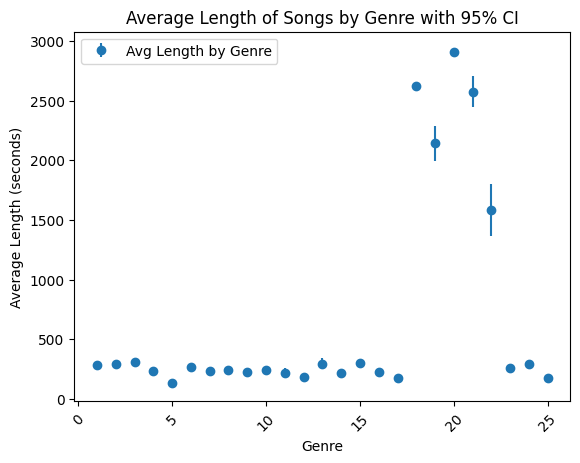

In [ ]:
# Merge track and genre data  
track_with_genre = track.merge(genre, on="genreid")  # Replace with actual column name  

# Convert milliseconds to seconds and handle any potential NaN values  
track_with_genre['length'] = track_with_genre['milliseconds'] / 1000  
track_with_genre.dropna(subset=['length'], inplace=True)  

# Calculate average length (in seconds) of songs per genre  
avg_length_by_genre = track_with_genre.groupby('genreid')['length'].agg(['mean', 'count', 'sem'])  

# 95% Confidence Interval  
ci_lower, ci_upper = stats.t.interval(  
    0.95,  
    df=avg_length_by_genre['count'] - 1,  
    loc=avg_length_by_genre['mean'],  
    scale=avg_length_by_genre['sem']  
)  

# Assign confidence intervals to DataFrame  
avg_length_by_genre['ci_lower'] = ci_lower  
avg_length_by_genre['ci_upper'] = ci_upper  

print(avg_length_by_genre)  

# Plotting Average Length by Genre  
plt.errorbar(  
    avg_length_by_genre.index,  
    avg_length_by_genre['mean'],  
    yerr=[avg_length_by_genre['ci_upper'] - avg_length_by_genre['mean'],  
          avg_length_by_genre['mean'] - avg_length_by_genre['ci_lower']],  
    fmt='o',  
    label='Avg Length by Genre'  
)  
plt.xticks(rotation=45)  
plt.title('Average Length of Songs by Genre with 95% CI')  
plt.xlabel('Genre')  
plt.ylabel('Average Length (seconds)')  
plt.legend()  
plt.show()

8.2. Average Sales in Different Countries

In [ ]:
# Calculate average sales per country  
avg_sales_by_country = invoice.groupby('billingcountry')['total'].agg(['mean', 'count', 'sem'])  

# 95% Confidence Interval  
ci_lower, ci_upper = stats.t.interval(0.95, avg_sales_by_country['count']-1,  
                                       loc=avg_sales_by_country['mean'],  
                                       scale=avg_sales_by_country['sem'])  

# Assign the confidence interval bounds to the DataFrame  
avg_sales_by_country['ci95_lower'] = ci_lower  
avg_sales_by_country['ci95_upper'] = ci_upper  

print(avg_sales_by_country)

                    mean  count       sem  ci95_lower  ci95_upper
billingcountry                                                   
Argentina       5.374286      7  1.753182    1.084404    9.664167
Australia       5.374286      7  1.753182    1.084404    9.664167
Austria         6.088571      7  2.367332    0.295920   11.881223
Belgium         5.374286      7  1.753182    1.084404    9.664167
Brazil          5.431429     35  0.730934    3.945992    6.916865
Canada          5.427857     56  0.578590    4.268338    6.587377
Chile           6.660000      7  2.498402    0.546630   12.773370
Czech Republic  6.445714     14  1.889366    2.363986   10.527442
Denmark         5.374286      7  1.753182    1.084404    9.664167
Finland         5.945714      7  1.769404    1.616139   10.275289
France          5.574286     35  0.756399    4.037098    7.111473
Germany         5.588571     28  0.886044    3.770560    7.406583
Hungary         6.517143      7  2.759062   -0.234038   13.268324
India     

Interpretation of the Data
Mean: The average number of songs purchased by users in each billing country. For instance, users in the Brazil region purchased an average of approximately 5.43 songs.

Count: The number of transactions that contributed to the mean calculation. For example, the mean for USA is based on 91 transactions, indicating a relatively robust sample size compared to others like Hungary and Chile, each with only 7 transactions.

Standard Error of the Mean (SEM): The standard deviation of the sampling distribution of the mean. A smaller SEM indicates that the sample mean is likely close to the true population mean. For USA, the SEM is 0.51, suggesting the mean is estimated with reasonable precision.

95% Confidence Interval:

ci95_lower: The lower boundary of the confidence interval.
ci95_upper: The upper boundary of the confidence interval.
For instance:

For Brazil, the 95% confidence interval is approximately (3.95, 6.92). This means you can be 95% confident that the true mean number of songs purchased by users in Brazil lies between 3.95 and 6.92.
In contrast, Hungary has a confidence interval that includes negative values (from -0.23 to 13.27), which suggests a lack of precision and potentially indicates that the mean may not be a reliable estimate due to the small sample size.
Key Observations
Small Sample Sizes: Countries with only a few transactions (e.g., Hungary, Chile, Finland) may have unreliable estimates of the mean due to high variability and wider confidence intervals. Such situations warrant cautious interpretation.

Different Purchasing Behaviors: The mean values might reflect differences in consumer behavior in different regions. For example, Canada and USA show a robust purchasing average with a larger number of transactions, likely reflecting more stable buying patterns.

8.3. Average Number of Songs Purchased by Each User

In [ ]:

  
invoice_sales = invoice.merge(invoiceline, on="invoiceid")  

# Calculate the total number of songs purchased by each customer   
purchases_per_user = invoice_sales.groupby('customerid')['quantity'].agg(['mean', 'count', 'sem'])


# 95% Confidence Interval  
# ci_lower, ci_upper = stats.t.interval(  
#     0.95,  
#     df=purchases_per_user['count'] - 1,  
#     loc=purchases_per_user['mean'],  
#     scale=purchases_per_user['sem']  
# )  
purchases_per_user['ci_lower'] = np.where(purchases_per_user['sem'] > 0,  
                                           ci_lower,  
                                           purchases_per_user['mean'])  
purchases_per_user['ci_upper'] = np.where(purchases_per_user['sem'] > 0,  
                                           ci_upper,  
                                           purchases_per_user['mean'])
# Assign confidence intervals to DataFrame  
purchases_per_user['ci_lower'] = ci_lower  
purchases_per_user['ci_upper'] = ci_upper    

# Display the summary  
print(purchases_per_user)

            mean  count  sem  ci_lower  ci_upper
customerid                                      
1            1.0     38  0.0       NaN       NaN
2            1.0     38  0.0       NaN       NaN
3            1.0     38  0.0       NaN       NaN
4            1.0     38  0.0       NaN       NaN
5            1.0     38  0.0       NaN       NaN
6            1.0     38  0.0       NaN       NaN
7            1.0     38  0.0       NaN       NaN
8            1.0     38  0.0       NaN       NaN
9            1.0     38  0.0       NaN       NaN
10           1.0     38  0.0       NaN       NaN
11           1.0     38  0.0       NaN       NaN
12           1.0     38  0.0       NaN       NaN
13           1.0     38  0.0       NaN       NaN
14           1.0     38  0.0       NaN       NaN
15           1.0     38  0.0       NaN       NaN
16           1.0     38  0.0       NaN       NaN
17           1.0     38  0.0       NaN       NaN
18           1.0     38  0.0       NaN       NaN
19           1.0    